In [1]:
from music21 import corpus, stream, note
import tensorflow as tf
import math
import random
import functools
import numpy as np

## some global constants

In [15]:
# number of voices
NUM_VOICES = 4

#number of output classes, i.e. half tone differences to melody
NUM_CLASSES = 26

# duration of time tick in beats. 1=quarter, 0.25=16th 
TIME_TICK = 0.25

# path of the trained model
INPUT_MODEL = "/home/lucky/models/208songsMajorMinor-2"

# minimum and maximum allowed midi key values of the melody
MELODY_MIN_PITCH = 59 # C-3
MELODY_MAX_PITCH = 83

# dir and name of the inference frozen model
FROZEN_MODEL_DIR = "/home/lucky/AnacondaProjects/neuronal-music-accompanist-bach/inference-model"
FROZEN_MODEL_NAME = "BachAccompanist.pb"

## create the inference model, import the trained model and export the inference model

In [122]:
  
# for state_is_tuple = True, currently does not work with undefined batch size
def get_state_variables(batch_size, cell):
    # For each layer, get the initial state and make a variable out of it
    # to enable updating its value.
    state_variables = []
    for state_c, state_h in cell.zero_state(batch_size, tf.float32):
        state_variables.append(tf.contrib.rnn.LSTMStateTuple(
            tf.Variable(state_c, trainable=False, name="rnn_state_c_%d" % (len(state_variables))),
            tf.Variable(state_h, trainable=False, name="rnn_state_h_%d" % (len(state_variables)))))
    # Return as a tuple, so that it can be fed to dynamic_rnn as an initial state
    return tuple(state_variables)


def get_state_update_op(state_variables, new_states):
    # Add an operation to update the lstm states with the last state tensors
    update_ops = []
    for state_variable, new_state in zip(state_variables, new_states):
        # Assign the new state to the state variables on this layer
        update_ops.extend([state_variable[0].assign(new_state[0]),
                           state_variable[1].assign(new_state[1])])
    # Return a tuple in order to combine all update_ops into a single operation.
    # The tuple's actual value should not be used.
    return tf.tuple(update_ops, name = "state_update")

def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper


class SequenceLabelling:

    # data[0]: midi note key, data[1]: 1 for strike, 0 for sustain note
    def __init__(self, data, seq_length=1, num_hidden=200, num_layers=1, NUM_VOICES = 4):
        self.data = data
        self._num_hidden = num_hidden
        self._num_layers = num_layers
        self.seq_length = seq_length
        self.output
        self.update_state
        self.rnn_input
        self.prediction

    @lazy_property
    def output(self):
        length = 1
        input_size = NUM_CLASSES + 1
        data_float = tf.cast(data, dtype=tf.float32)
        one_hot = tf.one_hot(data[0] - MELODY_MIN_PITCH, NUM_CLASSES, on_value=1., off_value=0., dtype=tf.float32)
        rnn_input = tf.reshape(tf.concat([one_hot, [data_float[1]]], 0), [1, 1, NUM_CLASSES + 1])
        print(rnn_input.shape)
        self.rnn_input = rnn_input
        
        # Recurrent network.
        cells = []
        for layer in range (0, self._num_layers):
            #cells.append(tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)) # or GRUCell)
            cells.append(tf.nn.rnn_cell.LSTMCell(self._num_hidden, state_is_tuple = True, use_peepholes=True))
        
        network = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple = True)
        #network = tf.contrib.rnn.GRUCell(self._num_hidden)
        
        # if state_is_tuple = True, does only work with defined batch size
        state = get_state_variables(rnn_input.shape[0], network)

        output, new_state = tf.nn.dynamic_rnn(network, rnn_input, dtype=tf.float32, initial_state = state)
        
        # Softmax layer for voices
        weight, bias = self._weight_and_bias(self._num_hidden, NUM_CLASSES * (NUM_VOICES - 1))
        # Flatten to apply same weights to all time steps.
        output = tf.reshape(output, [-1, self._num_hidden])
        prediction_voices = tf.matmul(output, weight) + bias
        prediction_voices = tf.nn.softmax(tf.reshape(prediction_voices, [-1, 1, (NUM_VOICES - 1), NUM_CLASSES]))
        print("prediction_voices:", prediction_voices.shape)
        
        # extract best prediction per voice
        output_voices = tf.cast(tf.reshape(tf.argmax(prediction_voices, axis = 3), [-1]), dtype=tf.float32)
        # convert the difference value to MIDI note key
        output_voices = tf.add(-output_voices, data_float[0])
        print("output_voices:", output_voices.shape)
        
        # strike layer for voices: 1 
        weight, bias = self._weight_and_bias(self._num_hidden, NUM_VOICES - 1)
        prediction_strike = tf.sigmoid(tf.reshape(tf.matmul(output, weight) + bias, [-1, self.seq_length, NUM_VOICES - 1, 1]))
        print("prediction_strike:", prediction_strike.shape)
        output_strike = tf.reshape(prediction_strike, [-1])
        print("output_strike:", output_strike.shape)
        
        
        self.prediction = tf.concat(axis = 3, values = [prediction_voices, prediction_strike], name = "prediction")
        output = tf.concat(axis = 0, values = [output_voices, output_strike], name = "output")
        
        
        # output is (NUM_VOICES -1) MIDI note key and (NUM_VOICES -1) strike/sustain probabilities
        print("output shape:", output.shape)
        
        
        
        # Add an operation to update the lstm states with the last state tensors.
        self.update_state = get_state_update_op(state, new_state)
        
        return output

    @staticmethod
    def _weight_and_bias(in_size, out_size):
        weight = tf.truncated_normal([in_size, out_size], stddev=0.01)
        bias = tf.constant(0.1, shape=[out_size])
        return tf.Variable(weight), tf.Variable(bias)

# Create new graph and export
g = tf.Graph()
with g.as_default():
    length = 1
    input_size = NUM_CLASSES + 1
    data = tf.placeholder(tf.int32, [2], name="input")
    print("input shape: ", data.shape)
    model = SequenceLabelling(data, num_hidden = 300, num_layers=3)
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    # import the weights
    train_saver = tf.train.Saver(tf.trainable_variables())
    train_saver.restore(sess, INPUT_MODEL)

    # export as frozen graph
    graph_def = g.as_graph_def()
    tf.train.write_graph(graph_def, FROZEN_MODEL_DIR, \
        FROZEN_MODEL_NAME, as_text=False)
    print("written model to ", FROZEN_MODEL_DIR, "/", FROZEN_MODEL_NAME)

input shape:  (2,)
(1, 1, 27)
prediction_voices: (1, 1, 3, 26)
output_voices: (3,)
prediction_strike: (1, 1, 3, 1)
output_strike: (3,)
output shape: (6,)
INFO:tensorflow:Restoring parameters from /home/lucky/models/208songsMajorMinor-2
written model to  /home/lucky/AnacondaProjects/neuronal-music-accompanist-bach/inference-model / BachAccompanist.pb


In [26]:
# read and test the model
g = tf.GraphDef()
g.ParseFromString(open(FROZEN_MODEL_DIR + "/" + FROZEN_MODEL_NAME, "rb").read())

print([n for n in g.node if n.name.find("input") != -1])
print([n for n in g.node if n.name.find("prediction") != -1])
print([n for n in g.node if n.name.find("output") != -1])

[name: "input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: 2
      }
    }
  }
}
]
[name: "prediction/axis"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
      }
      int_val: 3
    }
  }
}
, name: "prediction"
op: "ConcatV2"
input: "Reshape_4"
input: "Sigmoid"
input: "prediction/axis"
attr {
  key: "N"
  value {
    i: 2
  }
}
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "Tidx"
  value {
    type: DT_INT32
  }
}
]
[name: "output/axis"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
      }
      int_val: 0
    }
  }
}
, name: "output"
op: "ConcatV2"
input: "Cast"
input: "Reshape_7"
input: "output/axis"
attr {
  key: "N"
  value {
    i: 2
  }
}
at


## Apply the inference model
get a choral from the music21 Bach library and input the melody notes one by one to the rnn.


In [27]:
def extractMelody(music):
    min_midi = 256
    max_midi = 0
    melody = []
    currentOffset = 0
    for n in music.parts[0].flat.notes:
        #print("%s: %s %s %s" % (n.pitch.midi, n.pitch, n.offset, n.duration.quarterLength))
        while (n.offset > currentOffset):
            # insert breaks
            melody.append([currentOffset, 0, 1])
            currentOffset += TIME_TICK;
        noteTicks = math.floor(n.duration.quarterLength / TIME_TICK)
        min_midi = min(min_midi, n.pitch.midi)
        max_midi = max(max_midi, n.pitch.midi)
        for ticks in range(0, noteTicks):
            if (ticks == 0):
                melody.append([currentOffset, n.pitch.midi, 1])
            else:
                melody.append([currentOffset, n.pitch.midi, 0])
            currentOffset += TIME_TICK;
    #print("Melody min/max midi pitch: %d/%d" % (min_midi, max_midi))
    return melody

In [28]:
# calculate difference between melody and voice in halftones. 1: same halftone, 2: one halftone below 
# Limit to NUM_CLASSES. If the difference is greater, shift the voice by octaves.
def noteDifference(melody, voice):
    diff = melody - voice
    if diff < 0:  raise Exception("Error: voice above melody")
    # -1 for adding 1 below, additionl -1 so that diff can be index 
    while (diff > NUM_CLASSES - 2):
        diff -= 12
    return diff + 1

In [29]:
def extractVoices(melody, music):
    for partIndex in range(1, len(music.parts)):
        partNotes = music.parts[partIndex].flat.notes
        noteIndex = 0;
        maxNoteIndex = len(partNotes)
        
        for n in melody:
            #print(n)
            currentOffset = n[0]
            if (noteIndex < maxNoteIndex):
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset + voiceNote.duration.quarterLength <= currentOffset):
                    # skip to next note
                    noteIndex += 1
            if (noteIndex < maxNoteIndex):                
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset == currentOffset):
                    # new note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(1)
                elif (voiceNote.offset < currentOffset):
                    # continuing note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(0)
                else:
                    # between notes or behind last note, fill with empty 
                    n.append(0)
                    n.append(1)

In [30]:
songs = []
streams = []
for name in corpus.chorales.Iterator(1, 3, returnType='filename'):
    song = corpus.parse(name)
    key = song.analyze('key')
    highestTime = song.highestTime
    if len(song.parts) == 4 and highestTime < 68: 
        # and song.parts[0].flat.getTimeSignatures()[0].numerator == 3 and key.mode == 'major' 
        
        song.transpose(song.analyze('key').sharps, inPlace = True)
        #song.show()
        try:
            notes = extractMelody(song)
            extractVoices(notes, song)
            songs.append(notes)
            streams.append(song)
            print('%3d: %s: %s, %d, %s voices, duration: %s' % (
                len(songs), name, key, song.parts[0].flat.getTimeSignatures()[0].numerator, len(song.parts), highestTime))
            #song.show()
            #song.show('midi')
            
        except Exception as E:
            print(E)
            print("Error: %s not expected format, ignored" % name)
    #print(notes)

  1: bach/bwv153.1: a minor, 4, 4 voices, duration: 56.0


In [31]:
print(len(songs))

1


In [88]:
def createStream(music, numVoices=4):
    sc = stream.Score()
    notes = []
    for v in range(0, numVoices):
        sc.insert(0, stream.Part())
        notes.append(None)

    melodyPitchIndex = 1
        
    for tick in music:
        for voice in range (0, numVoices):
            part = sc.parts[voice]
            pitchIndex = 1 + voice * 2
            strikeIndex = 1 + voice * 2 + 1
            # extend note
            if notes[voice] != None and tick[strikeIndex] == 0:
                notes[voice].quarterLength += TIME_TICK
            
            if tick[strikeIndex] == 1:
                if (tick[pitchIndex]) > 0:
                    #create new note
                    n = note.Note()
                    notes[voice] = n
                    n.offset = tick[0]
                    if (voice == 0):
                        #melody voice
                        n.pitch.midi = tick[pitchIndex]
                    else:
                        #other voices relative to melody
                        n.pitch.midi = tick[pitchIndex] + 1
                    n.quarterLength = TIME_TICK
                    part.append(n)
                else:
                    n = note.Rest()
                    notes[voice] = n
                    n.offset = tick[0]
                    n.quarterLength = TIME_TICK
                    part.append(n)
    return sc
    
                        

In [89]:

def read_dataset(songs, NUM_VOICES = 4):
    seq_length = []
    for song in songs: seq_length.append(len(song))
    max_seq_length = max(seq_length)

    print("max sequence length: ", max_seq_length)
    
    m = len(songs)  
    print("num samples: ", m)
    X=[]
    Y=[]
    for sg in songs:
        x=[]
        y=[]
        #print(sg)
        for tick in sg:
            #print(tick)
            # add melody
            x.append([tick[1], tick[2]])
           
            voices = []
            # write voice pitch
            for voice in range(NUM_VOICES - 1):
                voice_index = 3 + voice * 2
                #print(oneHot)
                voices.append(tick[voice_index] + tick[1])
            # write voice strike
            for voice in range(NUM_VOICES - 1):
                voice_index = 3 + voice * 2 + 1
                #print(oneHot)
                voices.append(tick[voice_index])
            y.append(voices)
            #print("%s: %s -> %s" % (tick[0], tick[3], oneHot))
        # pad songs
        padding_length = max_seq_length - len(x)
        #print("padding:", padding_length)
        for i in range (0, padding_length):
            x.append([0] * 2)
            voices = []
            for voice in range(NUM_VOICES - 1):
                voices.append(np.zeros(2))
            y.append(voices)
        X.append(x)
        Y.append(y)   
    #print(Y[0])
    data = np.array(X)
    print("data: ", data.shape)
    target = np.array(Y)
    print("target: ", target.shape)
    dataset = {'data': data , 'target' : target, 'seq_length' : np.array(seq_length)}
    return dataset

train = read_dataset(songs)


max sequence length:  224
num samples:  1
data:  (1, 224, 2)
target:  (1, 224, 6)


In [125]:
from music21 import midi
def export_dataset(inSongs, prediction, NUM_VOICES = 4, strike_probability = 0.7):
    predSongs = []
    for i in range(0, min(len(inSongs), len(prediction))):
        song = []
        currentTime = 0.
        melody = inSongs[i]
        voices = prediction[i]
        predPitches = [0] * (NUM_VOICES - 1)
        predMelody = 0
        for tickNum in range(min(len(melody), len(voices))):
            tick = [currentTime, melody[tickNum][1], melody[tickNum][2]]
            for voice in range(NUM_VOICES - 1):
                predPitch = predPitches[voice]
                newPitch = voices[tickNum, voice]
                strike = voices[tickNum, voice + NUM_VOICES - 1] > strike_probability
                if not strike and predPitch > 0:
                    # if no strike than note cannot change
                    pitch = predPitch                
                else: pitch = newPitch
                tick.append(pitch)
                tick.append(strike)
                predPitches[voice] = pitch
            predMelody = melody[tickNum][1]
            #print(tick)
            song.append(tick)
            currentTime += TIME_TICK
        predSongs.append(song)
    return predSongs


In [128]:

predSongPieces = []
output = np.ndarray(shape=(1, 0, 6),  dtype=float)
print("sequence length: ", len(train['data'][0]))
for tick in range(len(train['data'][0])):
    tick_data = train['data'][0, tick]
    output_step, _ = sess.run([model.output, model.update_state], {
        data: tick_data})
    output = np.concatenate((output, output_step.reshape([1, 1, -1])), axis = 1)
    predSongPiece = export_dataset(songs, output)
    predSongPieces.append(predSongPiece[0])
        

sequence length:  224


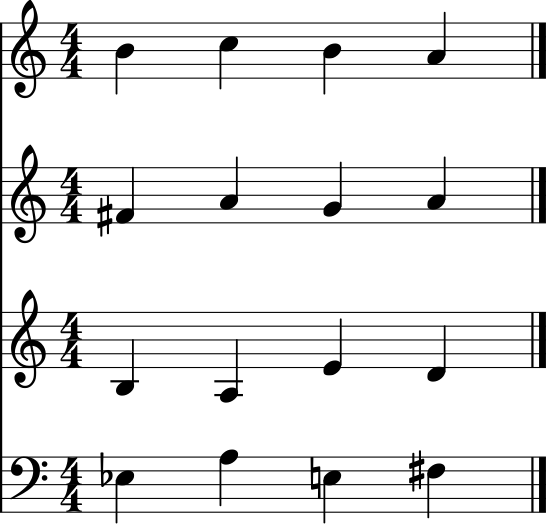

In [132]:
songNum = 15 # song containing the first 16 ticks - the first measure
sc = createStream(predSongPieces[songNum], 4)
sc.show()
sc.show('midi')
